In [123]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
from env import get_db_url
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import wrangle_zillow
import scipy.stats as stats
alpha = .05
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

### Acquire

In [2]:
df = wrangle_zillow.get_zillow_data()

In [3]:
df.shape

(52441, 68)

### Prepare
- Preparation steps include:
    - Removing columns and rows with more than 30% data missing.
    - Removed additional rows with null values.
    - Removed outliers (IQR and k =1.5)
    - Converted data types to integers
    - Labeled counties by name
    - Removed erroneous or duplicated columns
    - Created age, month_of_sale, taxvalue_per_sqft

- Feature ranges of homes:
- Data dictionary

In [4]:
df = wrangle_zillow.prepare_zillow_data(df)

In [5]:
df.shape

(33660, 18)

In [6]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale
0,3.5,4,3100,Orange,33634931,-117869207,4506,53571,96978,1998,1023282,11013,0.025595,2017-01-01,Single Family Residential,19,330,1
2,2.0,3,1243,Orange,33886168,-117823170,8432,21412,97078,1962,564778,6488,0.005383,2017-01-01,Single Family Residential,55,454,1
5,1.0,2,738,Los_Angeles,34149214,-118239357,4214,45457,96325,1922,218552,2366,0.101723,2017-01-01,Single Family Residential,95,296,1
7,3.0,4,2540,Los_Angeles,34434971,-118464390,10384,54311,96374,1999,430108,6103,0.005963,2017-01-02,Single Family Residential,18,169,1
9,2.5,3,1371,Ventura,34238229,-119170633,3445,13150,97107,2004,198054,2204,0.008669,2017-01-02,Single Family Residential,13,144,1


In [7]:
# split data
train, validate, test = wrangle_zillow.split_zillow_data(df)

In [8]:
train.shape, validate.shape, test.shape

((18849, 18), (8079, 18), (6732, 18))

### Explore

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Answer those questions through a mix of statistical tests and visualizations.

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,33660.0,2.087715e+00,0.686865,1.000000e+00,2.000000e+00,2.000000e+00,2.500000e+00,4.000000e+00
bedroomcnt,33660.0,3.221628e+00,0.767260,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
calculatedfinishedsquarefeet,33660.0,1.660689e+03,562.282346,4.800000e+02,1.242000e+03,1.552000e+03,1.983000e+03,3.522000e+03
latitude,33660.0,3.401917e+07,274278.706166,3.334425e+07,3.382422e+07,3.398879e+07,3.419368e+07,3.471836e+07
longitude,33660.0,-1.181808e+08,357826.205517,-1.194484e+08,-1.183726e+08,-1.181209e+08,-1.179262e+08,-1.175723e+08
lotsizesquarefeet,33660.0,6.629226e+03,2024.763938,1.350000e+03,5.429000e+03,6.500000e+03,7.670000e+03,1.243400e+04
regionidcity,33660.0,3.474437e+04,52429.771427,3.491000e+03,1.244700e+04,2.483200e+04,4.022700e+04,3.965560e+05
regionidzip,33660.0,9.660146e+04,1703.789228,9.598200e+04,9.622100e+04,9.645100e+04,9.700600e+04,3.996750e+05
yearbuilt,33660.0,1.963157e+03,20.041119,1.914000e+03,1.951000e+03,1.960000e+03,1.977000e+03,2.012000e+03
taxvaluedollarcnt,33660.0,3.531255e+05,218856.903437,3.254000e+03,1.749902e+05,3.290260e+05,4.940000e+05,1.070530e+06


In [10]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale
0,3.5,4,3100,Orange,33634931,-117869207,4506,53571,96978,1998,1023282,11013,0.025595,2017-01-01,Single Family Residential,19,330,1
2,2.0,3,1243,Orange,33886168,-117823170,8432,21412,97078,1962,564778,6488,0.005383,2017-01-01,Single Family Residential,55,454,1
5,1.0,2,738,Los_Angeles,34149214,-118239357,4214,45457,96325,1922,218552,2366,0.101723,2017-01-01,Single Family Residential,95,296,1
7,3.0,4,2540,Los_Angeles,34434971,-118464390,10384,54311,96374,1999,430108,6103,0.005963,2017-01-02,Single Family Residential,18,169,1
9,2.5,3,1371,Ventura,34238229,-119170633,3445,13150,97107,2004,198054,2204,0.008669,2017-01-02,Single Family Residential,13,144,1


In [11]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bathroomcnt
2.0    16649
3.0     6401
1.0     6164
2.5     3115
1.5      547
4.0      511
3.5      273
Name: bathroomcnt, dtype: int64
-------------------------------
bedroomcnt
3    16956
4     9700
2     5416
5     1588
Name: bedroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120    106
1200     85
1570     69
1400     69
1080     68
       ... 
2869      1
562       1
3231      1
598       1
512       1
Name: calculatedfinishedsquarefeet, Length: 2715, dtype: int64
-------------------------------
fips
Los_Angeles    21173
Orange          9478
Ventura         3009
Name: fips, dtype: int64
-------------------------------
latitude
34712133    4
34229075    4
34163686    3
33770026    3
33914773    3
           ..
34022001    1
33883380    1
34233017    1
33973025    1
33937685    1
Name: latitude, Length: 32820, dtype: int64
-------------------------------
longitude
-117847000    5
-117849000    4
-117762000    4
-117768000    3
-118338656    3
     

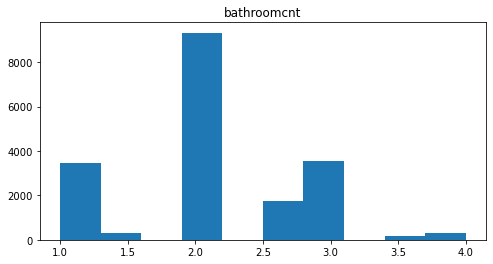

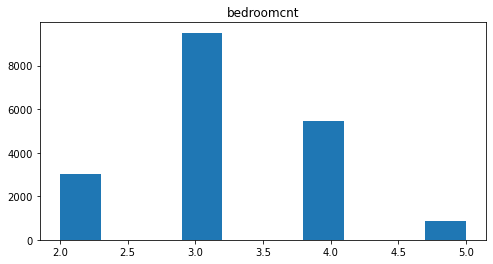

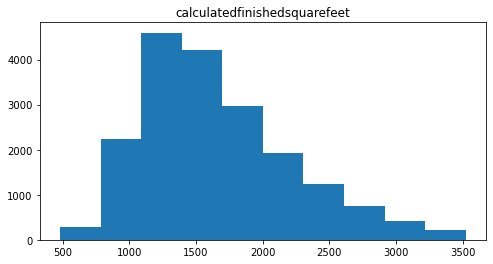

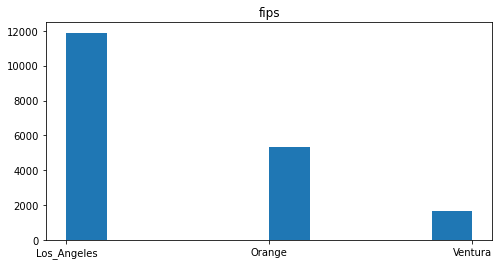

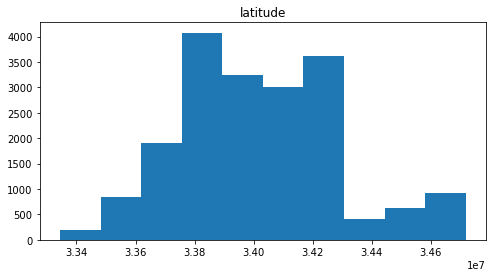

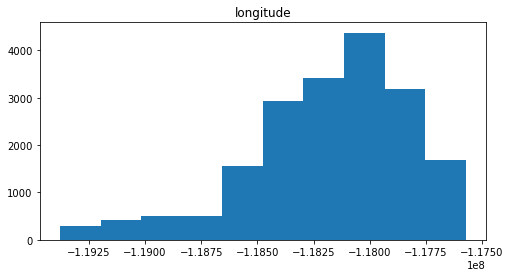

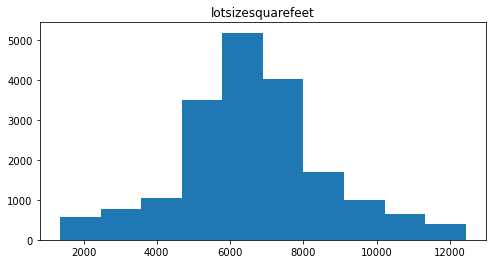

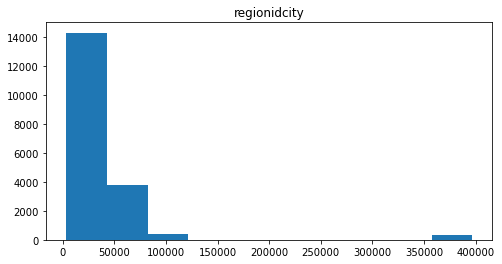

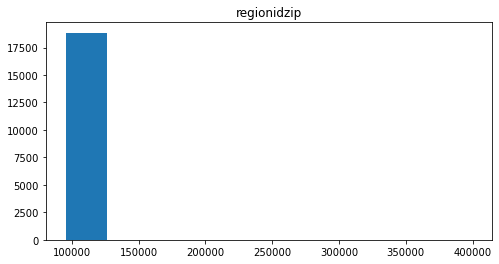

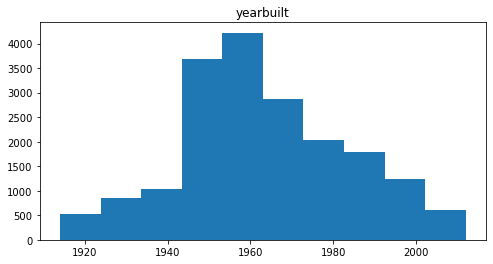

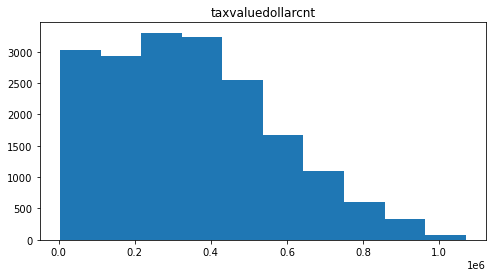

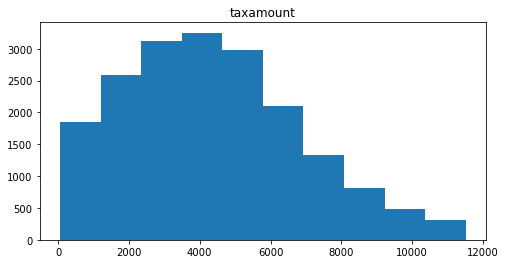

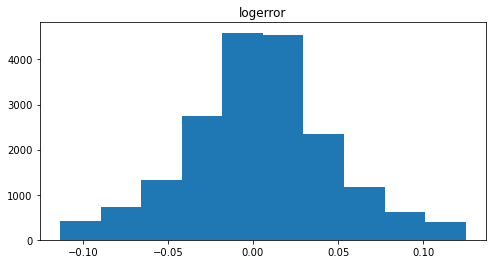

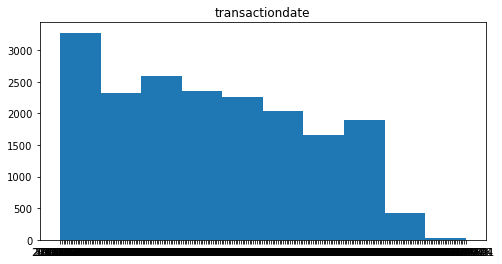

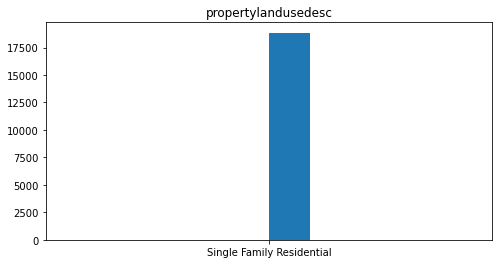

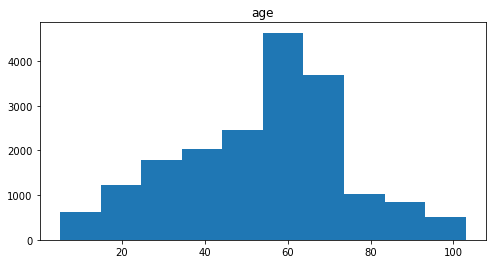

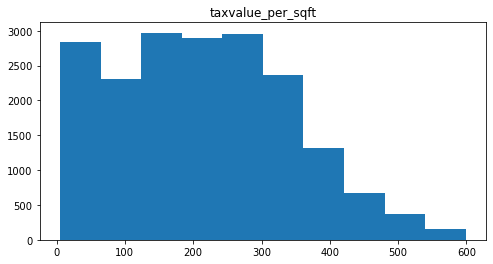

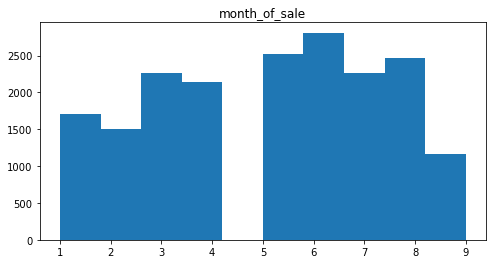

In [12]:
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(8,4))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Questions to ask:
   - Is log error dependent on county?
   - Are log error and tax value related?
   - Are log error and square feet related?
   - Are log error and tax value per square feet related?
   - Are log error and age related?
   - Are log error and latitude/longitude related?
    

### Log error and county

<AxesSubplot:title={'center':'Is log error dependent on County?'}, xlabel='fips', ylabel='logerror'>

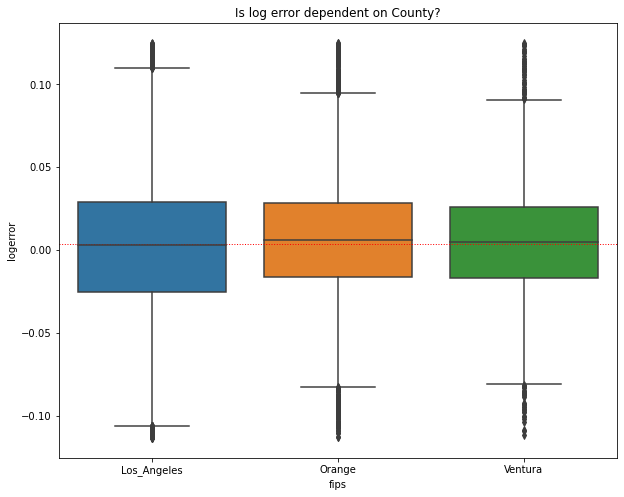

In [13]:
plt.figure(figsize=(10,8))
plt.title("Is log error dependent on County?")
plt.axhline(train.logerror.mean(),ls= ':', color = 'red', linewidth=1)
sns.boxplot(x=train.fips, y=train.logerror)

**Notes:**
- LA county's median value is more closely centered around zero, while Orange and Ventura counties have a higher median logerror.


Next step:
- Run statistical tests to determine if there is a difference in each county and the population mean.

- Null Hypothesis: The mean logerror of LA County is >= than the population mean.
- Alternative Hypothesis: The mean logerror of LA County is < than the population mean.

In [14]:
t, p = stats.ttest_1samp(train[train.fips=='Los_Angeles'].logerror.mean(), train.logerror.mean())

t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Ventura County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Ventura County is > than the population mean.

In [15]:
t, p = stats.ttest_1samp(train[train.fips=='Ventura'].logerror.mean(), train.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Orange County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Orange County is > than the population mean.

In [16]:
t, p = stats.ttest_1samp(train[train.fips=='Orange'].logerror.mean(), train.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


In [17]:
df.logerror.mean(),train[train.fips=='Los_Angeles'].logerror.mean(), train[train.fips=='Ventura'].logerror.mean(), train[train.fips=='Orange'].logerror.mean()

(0.003940897366241479,
 0.0023822000199928656,
 0.0056996688918747014,
 0.0068176523245103)

**Notes: We can conclude, with statistical significance, that the means of the logerror of each county are not equal. LA County's logerror is less than the population, while Orange and Ventura counties' logerror means are greater than the population.**

### Log error and tax value

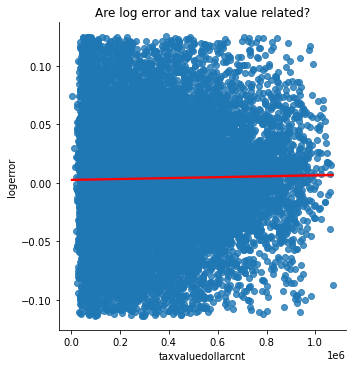

In [18]:
sns.lmplot(data=train, x='taxvaluedollarcnt',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and tax value related?")
plt.show()

Slight increase in error as values increase.

<AxesSubplot:>

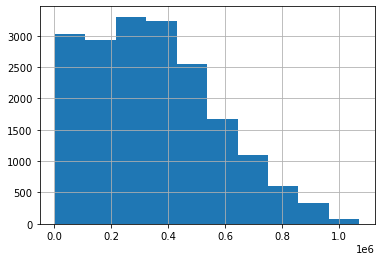

In [19]:
train.taxvaluedollarcnt.hist()

- Null Hypothesis: There is no linear correlation between tax value and log error.
- Alternative Hypothesis: There is a lonear correlation between tax value and log error.

In [20]:
# perform correlation testing on taxvaluedollar count and logerror
alpha=.05
corr, p = stats.spearmanr(train.taxvaluedollarcnt, train.logerror)
p < alpha, corr, p

(True, 0.01500189594050002, 0.03943540885960506)

**Reject the null hypothesis.**
There is a very weak positive correlation.

In [21]:
corr = pd.DataFrame(train.corr(method='spearman'))
corr

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,age,taxvalue_per_sqft,month_of_sale
bathroomcnt,1.000000,0.553771,0.787263,-0.028695,0.104456,0.118753,0.002322,0.278291,0.606400,0.361314,0.364331,0.066753,-0.606400,-0.030394,0.019287
bedroomcnt,0.553771,1.000000,0.601850,0.007584,0.056120,0.213064,0.011457,0.220009,0.394019,0.189390,0.198042,0.036481,-0.394019,-0.117292,0.008053
calculatedfinishedsquarefeet,0.787263,0.601850,1.000000,-0.042847,0.087094,0.251690,-0.000329,0.241450,0.529788,0.392402,0.394698,0.078448,-0.529788,-0.097513,0.015384
latitude,-0.028695,0.007584,-0.042847,1.000000,-0.652440,0.322287,-0.167135,0.124715,-0.003788,-0.170227,-0.100933,-0.032425,0.003788,-0.159670,-0.003578
longitude,0.104456,0.056120,0.087094,-0.652440,1.000000,-0.097501,0.092136,0.267727,0.215561,0.057886,0.032319,0.018375,-0.215561,0.015707,-0.011693
lotsizesquarefeet,0.118753,0.213064,0.251690,0.322287,-0.097501,1.000000,-0.074265,0.168333,0.003527,-0.002830,0.014233,-0.012326,-0.003527,-0.131936,0.006577
regionidcity,0.002322,0.011457,-0.000329,-0.167135,0.092136,-0.074265,1.000000,0.014022,0.016669,0.065332,0.061209,0.011890,-0.016669,0.068338,0.001224
regionidzip,0.278291,0.220009,0.241450,0.124715,0.267727,0.168333,0.014022,1.000000,0.555653,0.051237,0.047682,0.024668,-0.555653,-0.075931,0.000324
yearbuilt,0.606400,0.394019,0.529788,-0.003788,0.215561,0.003527,0.016669,0.555653,1.000000,0.259124,0.267570,0.044269,-1.000000,-0.011868,0.018324
taxvaluedollarcnt,0.361314,0.189390,0.392402,-0.170227,0.057886,-0.002830,0.065332,0.051237,0.259124,1.000000,0.971897,0.015002,-0.259124,0.853820,0.033550


In [22]:
corr.logerror.sort_values(ascending=False)

logerror                        1.000000
calculatedfinishedsquarefeet    0.078448
bathroomcnt                     0.066753
yearbuilt                       0.044269
bedroomcnt                      0.036481
month_of_sale                   0.028788
regionidzip                     0.024668
longitude                       0.018375
taxvaluedollarcnt               0.015002
regionidcity                    0.011890
taxamount                       0.007004
lotsizesquarefeet              -0.012326
taxvalue_per_sqft              -0.026687
latitude                       -0.032425
age                            -0.044269
Name: logerror, dtype: float64

In [23]:
corr_p = pd.DataFrame(train.corr(method='pearson'))
corr_p

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,age,taxvalue_per_sqft,month_of_sale
bathroomcnt,1.000000,0.563657,0.768436,0.010551,0.042321,0.137560,-0.068949,0.049177,0.566570,0.368086,0.371649,0.064624,-0.566570,-0.065079,0.018799
bedroomcnt,0.563657,1.000000,0.595143,0.029016,0.004397,0.215503,-0.062130,0.037230,0.359614,0.199706,0.205810,0.039748,-0.359614,-0.140536,0.006510
calculatedfinishedsquarefeet,0.768436,0.595143,1.000000,-0.028633,0.044961,0.261107,-0.062023,0.043864,0.510558,0.436508,0.435789,0.080020,-0.510558,-0.118982,0.015729
latitude,0.010551,0.029016,-0.028633,1.000000,-0.544904,0.301201,0.001858,0.023626,0.091502,-0.219321,-0.130289,-0.034330,-0.091502,-0.200486,-0.004004
longitude,0.042321,0.004397,0.044961,-0.544904,1.000000,-0.117018,-0.016052,0.034636,0.092467,0.033726,0.019503,0.009725,-0.092467,0.001412,-0.014149
lotsizesquarefeet,0.137560,0.215503,0.261107,0.301201,-0.117018,1.000000,-0.027765,0.012298,-0.029342,0.015758,0.027722,-0.008554,0.029342,-0.129352,0.006109
regionidcity,-0.068949,-0.062130,-0.062023,0.001858,-0.016052,-0.027765,1.000000,-0.024863,-0.116713,0.002965,-0.005696,-0.005438,0.116713,0.043098,-0.015298
regionidzip,0.049177,0.037230,0.043864,0.023626,0.034636,0.012298,-0.024863,1.000000,0.100243,0.001624,-0.000943,0.010116,-0.100243,-0.025643,-0.000383
yearbuilt,0.566570,0.359614,0.510558,0.091502,0.092467,-0.029342,-0.116713,0.100243,1.000000,0.263959,0.282283,0.042010,-1.000000,-0.034968,0.016498
taxvaluedollarcnt,0.368086,0.199706,0.436508,-0.219321,0.033726,0.015758,0.002965,0.001624,0.263959,1.000000,0.966831,0.019924,-0.263959,0.797684,0.032130


In [24]:
corr_p.logerror.sort_values(ascending=False)

logerror                        1.000000
calculatedfinishedsquarefeet    0.080020
bathroomcnt                     0.064624
yearbuilt                       0.042010
bedroomcnt                      0.039748
taxvaluedollarcnt               0.019924
month_of_sale                   0.015712
taxamount                       0.012199
regionidzip                     0.010116
longitude                       0.009725
regionidcity                   -0.005438
lotsizesquarefeet              -0.008554
taxvalue_per_sqft              -0.026848
latitude                       -0.034330
age                            -0.042010
Name: logerror, dtype: float64

### Log error and square feet

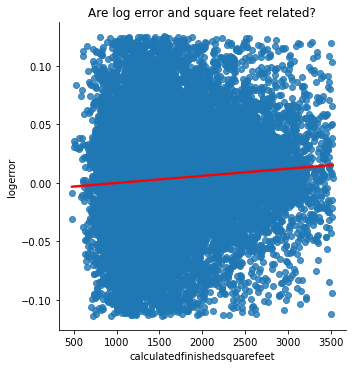

In [25]:
sns.lmplot(data=train, x='calculatedfinishedsquarefeet',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and square feet related?")
plt.show()

<AxesSubplot:>

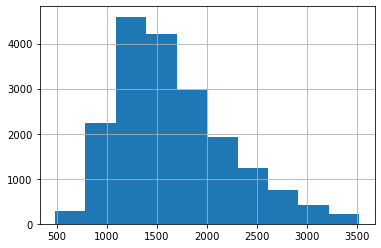

In [26]:
train.calculatedfinishedsquarefeet.hist()

In [27]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(train.calculatedfinishedsquarefeet, train.logerror)
p < alpha, corr, p

(True, 0.07844755708028653, 4.003996331739839e-27)

**Reject the null hypothesis.** While weak, this is the strongest correlation with log error.

### Log error and tax value per square feet

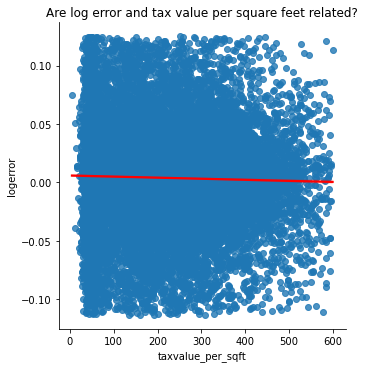

In [28]:
sns.lmplot(data=train, x='taxvalue_per_sqft',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and tax value per square feet related?")
plt.show()

<AxesSubplot:>

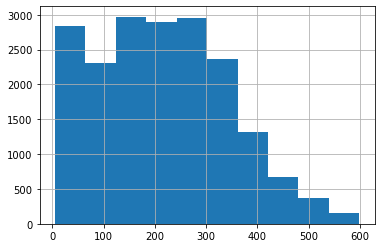

In [29]:
train.taxvalue_per_sqft.hist()

In [30]:
# perform correlation testing on taxvaluepersqft count and logerror
alpha=.05
corr, p = stats.spearmanr(train.taxvalue_per_sqft, train.logerror)
p < alpha, corr, p

(True, -0.026686864469764683, 0.0002480222445226254)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and age

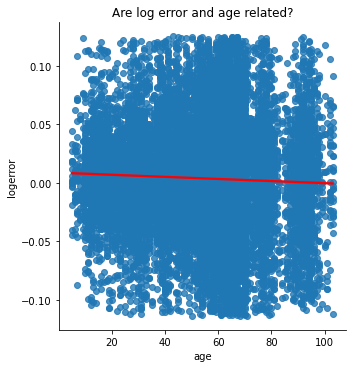

In [31]:
sns.lmplot(data=train, x='age',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and age related?")
plt.show()

In [32]:
# perform correlation testing on taxvaluepersqft count and logerror
alpha=.05
corr, p = stats.pearsonr(train.age, train.logerror)
p < alpha, corr, p

(True, -0.04201049550159269, 7.933964116653264e-09)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and latitude

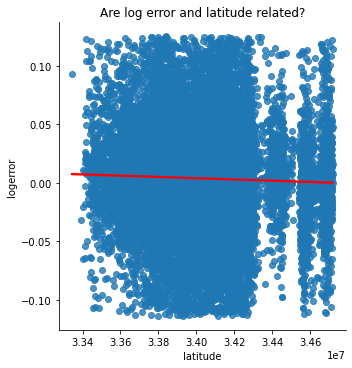

In [33]:
sns.lmplot(data=train, x='latitude',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and latitude related?")
plt.show()

In [34]:
alpha=.05
corr, p = stats.pearsonr(train.latitude, train.logerror)
p < alpha, corr, p

(True, -0.03433005394750692, 2.425347258112339e-06)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and longitude

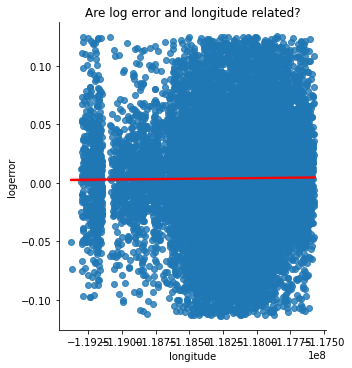

In [35]:
sns.lmplot(data=train, x='longitude',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and longitude related?")
plt.show()

<AxesSubplot:>

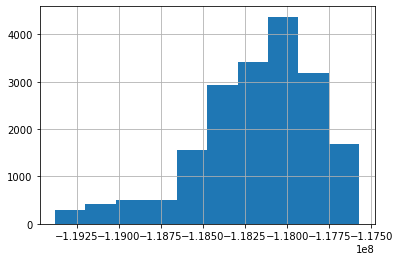

In [36]:
train.longitude.hist()

In [37]:
alpha=.05
corr, p = stats.spearmanr(train.longitude, train.logerror)
p < alpha, corr, p

(True, 0.01837548501702637, 0.011640919372846382)

**Reject the null hypothesis.** There is a weak positive correlation.

In [38]:
def calculate_pvalues_spearman(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [stats.spearmanr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

In [39]:
pvalues_s = calculate_pvalues_spearman(train)

In [40]:
pvalues_s.logerror < alpha

age                              True
bathroomcnt                      True
bedroomcnt                       True
calculatedfinishedsquarefeet     True
latitude                         True
logerror                         True
longitude                        True
lotsizesquarefeet               False
month_of_sale                    True
regionidcity                    False
regionidzip                      True
taxamount                       False
taxvalue_per_sqft                True
taxvaluedollarcnt                True
yearbuilt                        True
Name: logerror, dtype: bool

In [41]:
def calculate_pvalues_pearson(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [stats.pearsonr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

In [42]:
pvalues_p = calculate_pvalues_pearson(train)

In [43]:
pvalues_p.logerror < alpha

age                              True
bathroomcnt                      True
bedroomcnt                       True
calculatedfinishedsquarefeet     True
latitude                         True
logerror                         True
longitude                       False
lotsizesquarefeet               False
month_of_sale                    True
regionidcity                    False
regionidzip                     False
taxamount                       False
taxvalue_per_sqft                True
taxvaluedollarcnt                True
yearbuilt                        True
Name: logerror, dtype: bool

### Answers to questions:
- Log error differs by county.
- Log error increases as tax values increases.
- Log error decreases as the home of the age increases.
- **Log error increases as the size of the home increases.**
- Log error decreases as the tax value per square feet increases.
- There is a relationship between log error and latitude and longitude.

- The strongest correlation with log error is square feet, followed by age, latitude, tax value per square feet, longitude, and tax value.


Things to try next:
- Look into data after clustering

<Figure size 1440x2160 with 0 Axes>

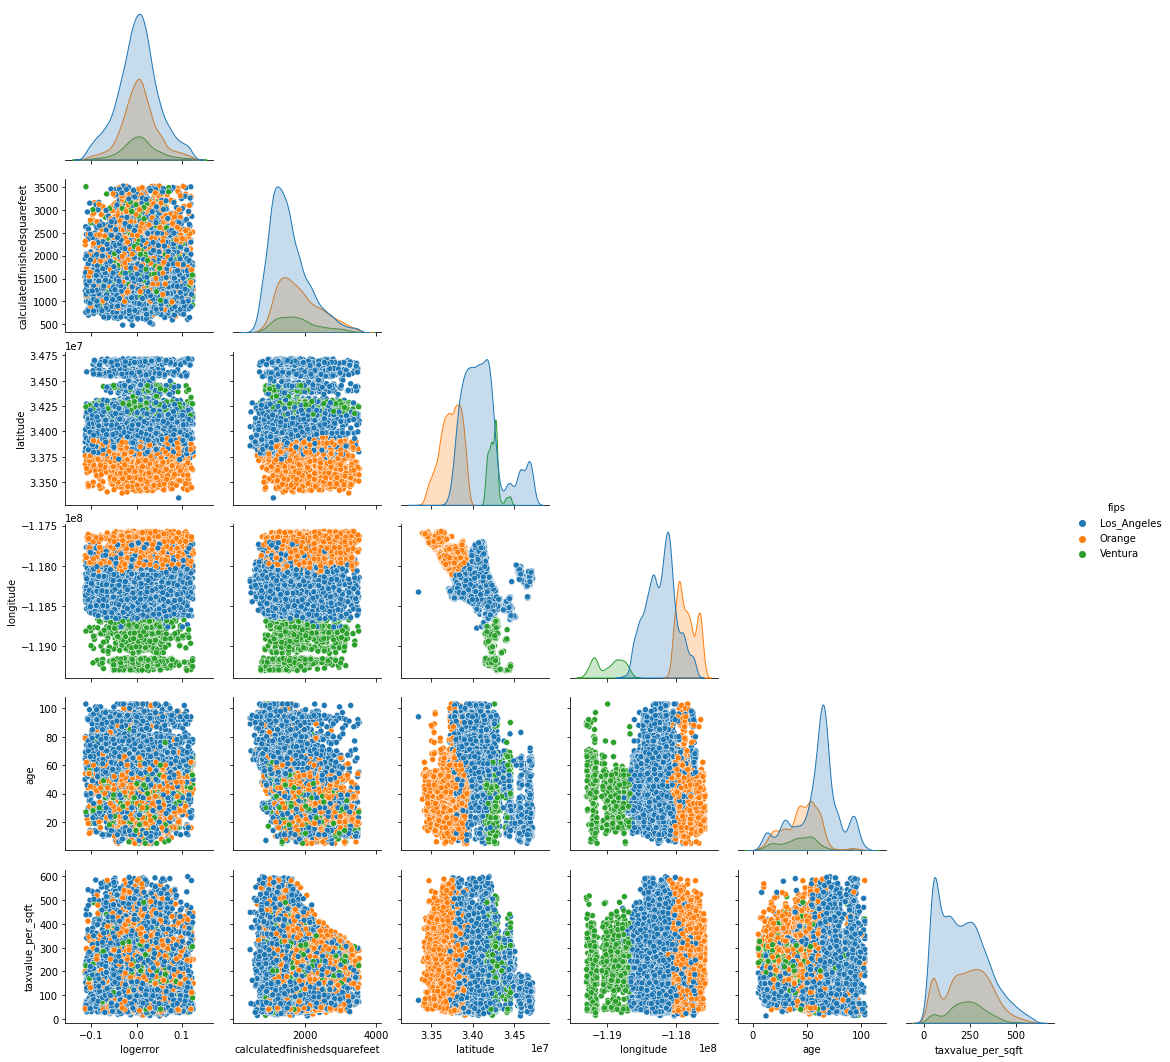

In [44]:
plt.figure(figsize = (20,30))
sns.pairplot(data=train.sample(10000), x_vars=['logerror', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxvalue_per_sqft'],
                  y_vars=['logerror', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxvalue_per_sqft'],
             hue = "fips", corner=True)


- **Latitude and longitude obviously make clear county clusters.**
- **Longitude clearly defined with logerror and taxvalue per square feet**

### Clustering

#### Clustering by latitude/longitude

In [45]:
train_scaled, validate_scaled, test_scaled = wrangle_zillow.scale_data(train,validate,test)

In [46]:
X_train = train_scaled[['latitude','longitude']]
X_validate = validate_scaled[['latitude','longitude']]
X_test = test_scaled[['latitude','longitude']]

In [52]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([2, 6, 2, ..., 5, 5, 1], dtype=int32)

In [53]:
train_scaled['clusters_by_lat_long'] = kmeans.predict(X_train)
validate_scaled['clusters_by_lat_long'] = kmeans.predict(X_validate)
test_scaled['clusters_by_lat_long'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters')

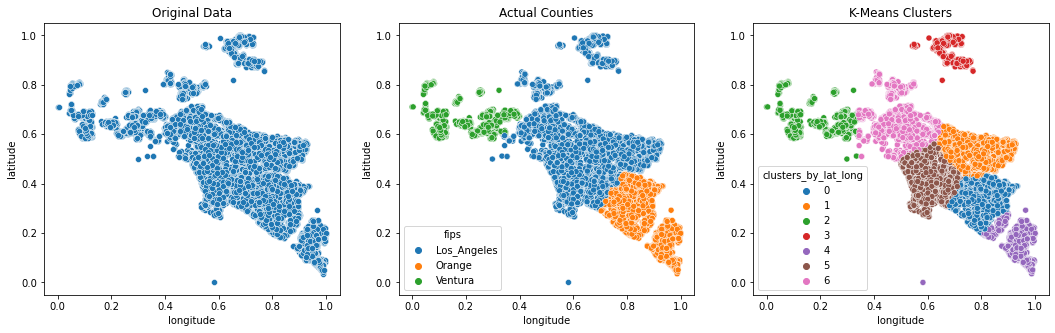

In [54]:
plt.figure(figsize=(18,5))
plt.subplot(131)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude')
plt.title('Original Data')

plt.subplot(132)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'fips')
plt.title('Actual Counties')

plt.subplot(133)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'clusters_by_lat_long', palette = ('tab10'))
plt.title('K-Means Clusters')

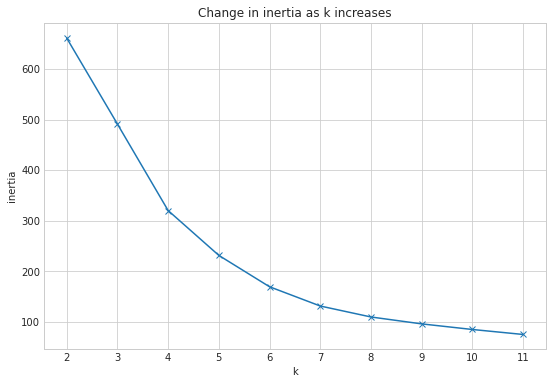

In [55]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### Clustering by age and square feet

In [57]:
X_train = train_scaled[[ 'age','calculatedfinishedsquarefeet']]
X_validate = validate_scaled[[ 'age','calculatedfinishedsquarefeet']]
X_test = test_scaled[[ 'age','calculatedfinishedsquarefeet']]

In [66]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([3, 0, 5, ..., 0, 4, 0], dtype=int32)

In [67]:
train_scaled['clusters_scaled'] = kmeans.predict(X_train)
validate_scaled['clusters_scaled'] = kmeans.predict(X_validate)
test_scaled['clusters_scaled'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters')

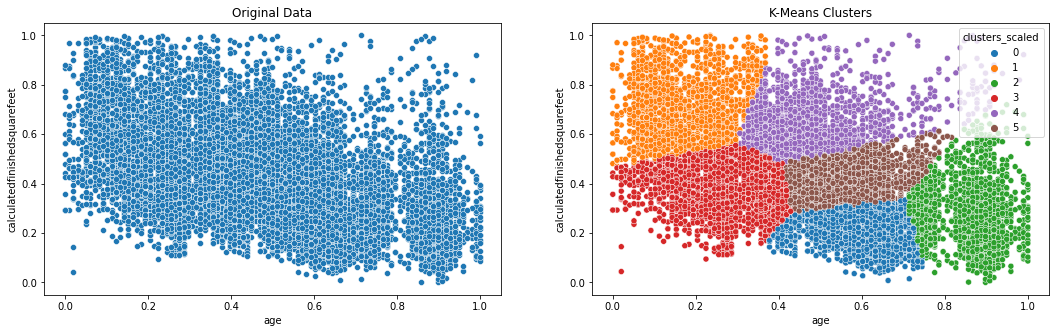

In [68]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.scatterplot(data = train_scaled, x = 'age', y = 'calculatedfinishedsquarefeet')
plt.title('Original Data')

plt.subplot(122)
sns.scatterplot(data = train_scaled, x = 'age', y = 'calculatedfinishedsquarefeet', hue = 'clusters_scaled', palette = ('tab10'))
plt.title('K-Means Clusters')

In [69]:
validate_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long,clusters_scaled
31531,0.333333,0.333333,0.223537,Los_Angeles,0.638121,0.463895,0.570345,12447,96354,0.448980,0.052990,842,-0.005874,2017-06-15,Single Family Residential,0.551020,0.077441,0.625,6,0
23825,0.666667,0.333333,0.382643,Los_Angeles,0.630944,0.447832,0.560321,12447,96341,0.408163,0.225870,3142,0.049696,2017-05-11,Single Family Residential,0.591837,0.240741,0.500,6,5
27072,0.666667,0.666667,0.674227,Ventura,0.700119,0.300623,0.396785,25974,97097,0.836735,0.379563,4478,-0.001256,2017-05-26,Single Family Residential,0.163265,0.262626,0.500,2,1
45177,0.000000,0.333333,0.381328,Los_Angeles,0.540503,0.741758,0.370056,51861,96478,0.377551,0.394120,6320,0.012967,2017-08-15,Single Family Residential,0.622449,0.425926,0.875,1,5
34319,0.666667,0.666667,0.619001,Los_Angeles,0.930462,0.652109,0.419812,40227,97329,0.918367,0.096042,2598,-0.027416,2017-06-27,Single Family Residential,0.081633,0.065657,0.625,3,1


Text(0.5, 1.0, 'K-Means Clusters - validate')

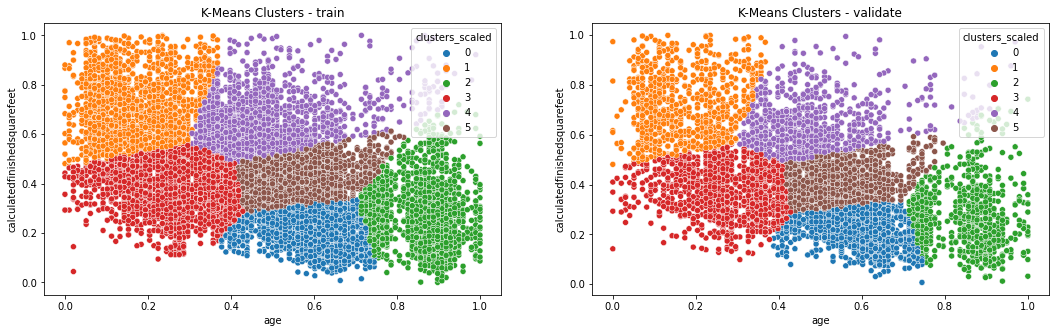

In [70]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.scatterplot(data = train_scaled, x = 'age', y = 'calculatedfinishedsquarefeet', hue = 'clusters_scaled', palette = ('tab10'))
plt.title('K-Means Clusters - train')

plt.subplot(122)
sns.scatterplot(data = validate_scaled, x = 'age', y = 'calculatedfinishedsquarefeet', hue = 'clusters_scaled', palette = ('tab10'))
plt.title('K-Means Clusters - validate')

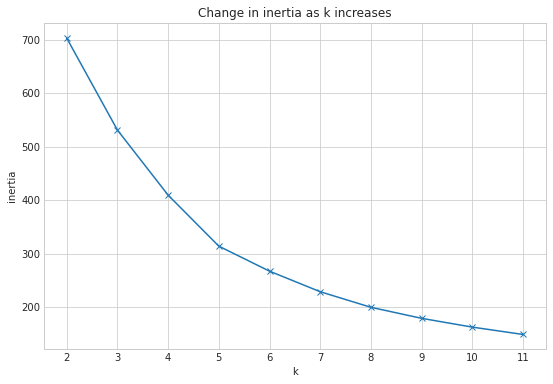

In [72]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- **Notes: With locational clustering we can divide the 3 counties to 6 regions and may be better able to predict log error.**
- **

### View log error by clusters of age and square feet

In [78]:
train_scaled.clusters_scaled.value_counts()

0    5478
5    4112
3    3451
4    2010
2    1904
1    1894
Name: clusters_scaled, dtype: int64

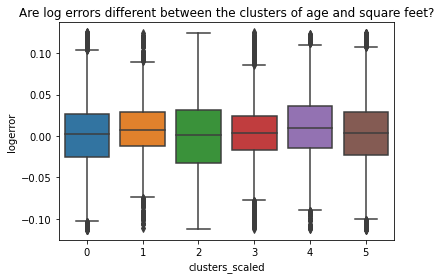

In [402]:
sns.boxplot(data=train_scaled,x='clusters_scaled',y='logerror')
plt.title("Are log errors different between the clusters of age and square feet?")
plt.show()

In [98]:
train_scaled.groupby('clusters_scaled').logerror.mean()

clusters_scaled
0    0.001240
1    0.008131
2   -0.000005
3    0.004261
4    0.010884
5    0.003688
Name: logerror, dtype: float64

### View log error by clusters of latitude and longitude

In [76]:
train_scaled.clusters_by_lat_long.value_counts()

0    4219
5    3627
6    3486
1    3083
4    1747
2    1363
3    1324
Name: clusters_by_lat_long, dtype: int64

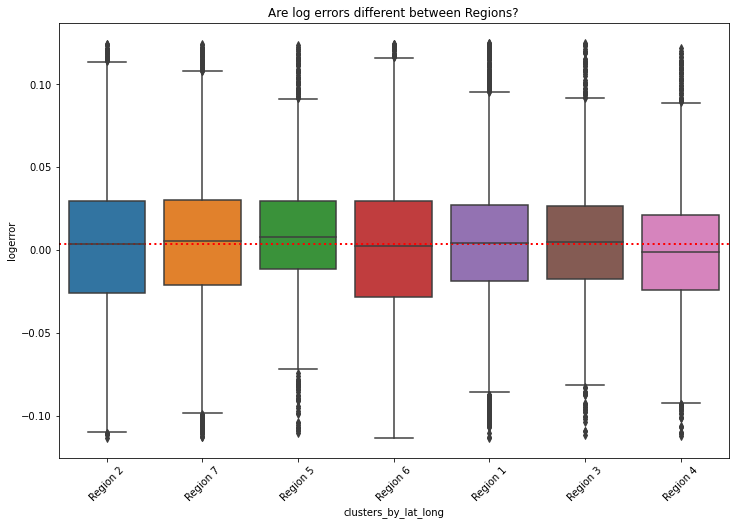

In [408]:
plt.figure(figsize=(12,8))
sns.boxplot(data=train_scaled,x='clusters_by_lat_long',y='logerror')

plt.title("Are log errors different between Regions?")
plt.xticks(rotation=45)
plt.axhline(train_scaled.logerror.mean(),ls= ':', color = 'red', linewidth=2)
plt.show()

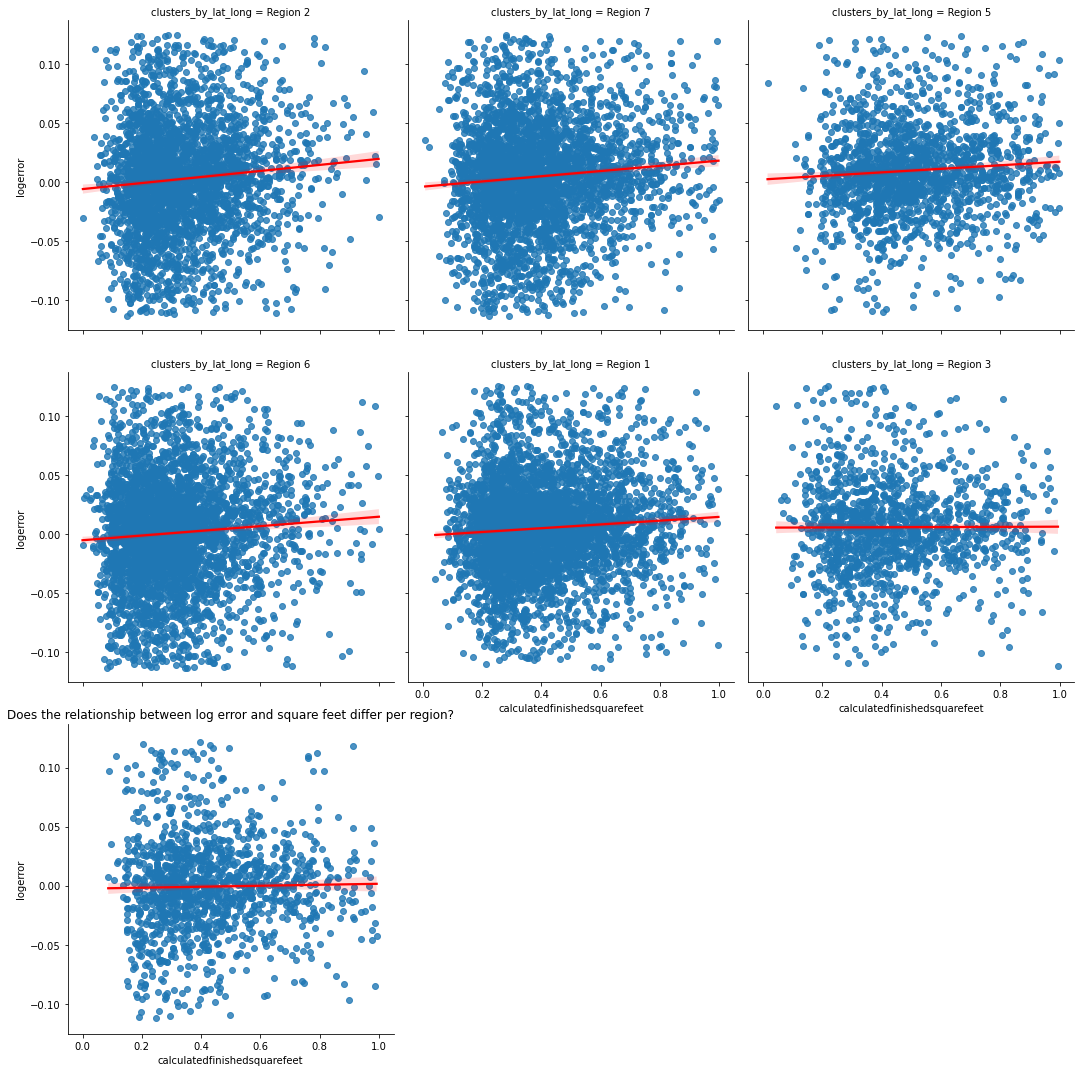

In [428]:
sns.lmplot(data=train_scaled,x='calculatedfinishedsquarefeet',y='logerror', col='clusters_by_lat_long', col_wrap=3, line_kws={'color':'red'})
plt.title("Does the relationship between log error and square feet differ per region?")
plt.show()

Visualize distribution of log error by region

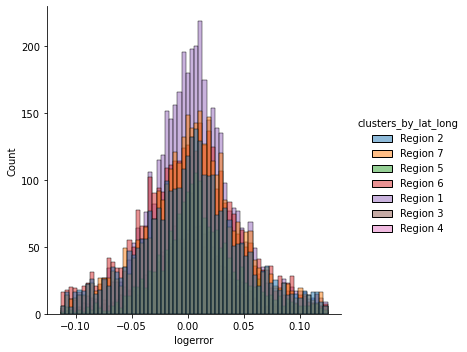

In [276]:
sns.displot(data=train_scaled,x='logerror', hue ='clusters_by_lat_long')

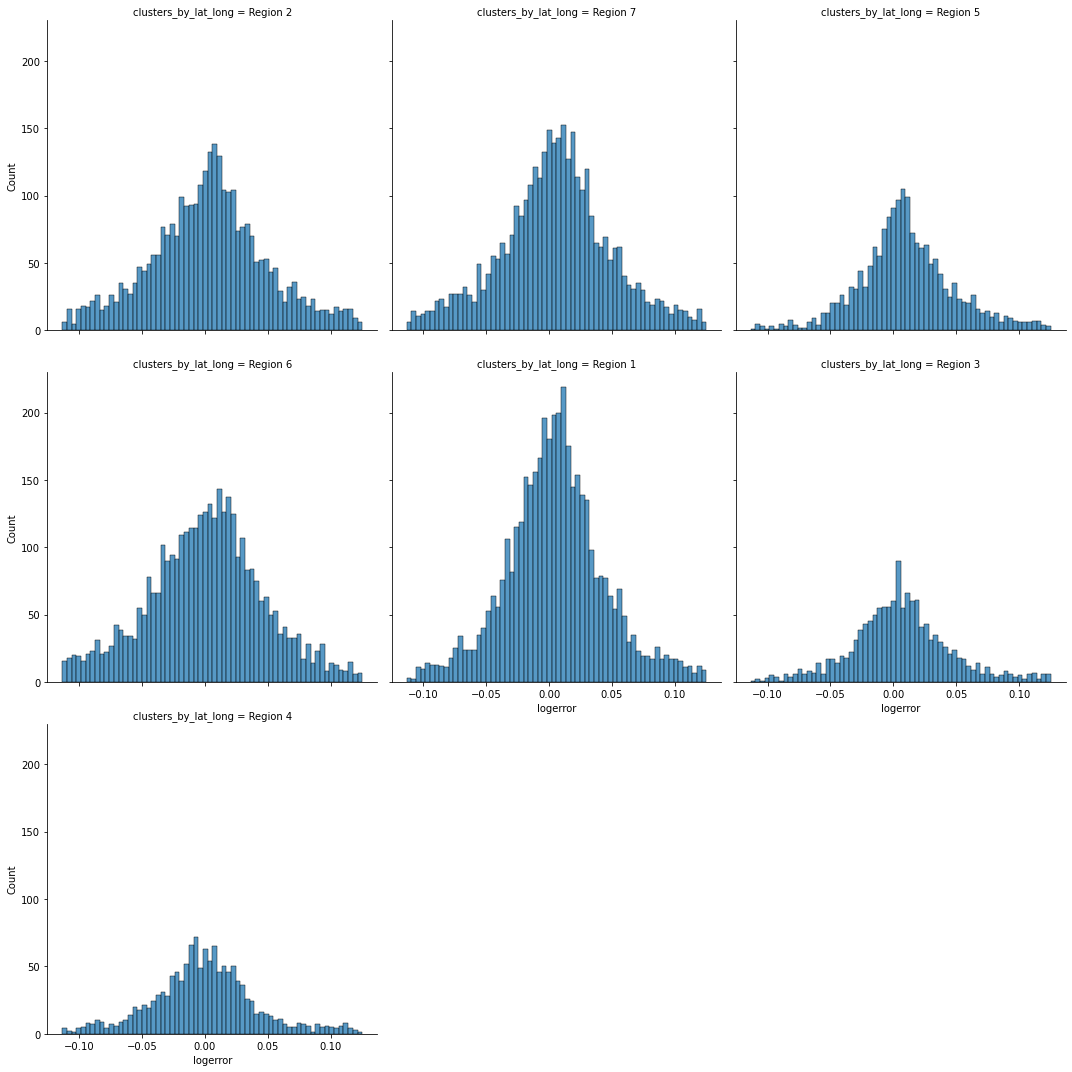

In [251]:
sns.displot(data=train_scaled,x='logerror', col ='clusters_by_lat_long', col_wrap =3)
# plt.axvline(np.std(train_scaled.groupby('clusters_by_lat_long').logerror),ls= ':', color = 'red', linewidth=1)

In [163]:
train_scaled.groupby('clusters_by_lat_long').logerror.median()

clusters_by_lat_long
0    0.004269
1    0.003606
2    0.004745
3   -0.001103
4    0.007692
5    0.002235
6    0.005581
Name: logerror, dtype: float64

In [164]:
 def map_clusters(df):
     # identified counties for fips codes 
     clusters = {0: 'Region 1',
                 1: 'Region 2',
                 2: 'Region 3',
                 3: 'Region 4',
                 4: 'Region 5',
                 5: 'Region 6',
                 6: 'Region 7'}
     # map clusters 
     df.clusters_by_lat_long= df.clusters_by_lat_long.map(clusters)
     return df

In [165]:
map_clusters(train_scaled)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long,clusters_scaled
51081,1.000000,0.666667,0.775477,Los_Angeles,0.582710,0.819429,0.288785,37015,96464,1.000000,0.513521,8650,0.033457,2017-09-11,Single Family Residential,0.000000,0.318182,1.000,Region 2,1
28594,0.333333,0.333333,0.469099,Los_Angeles,0.607354,0.426485,0.557161,12447,96389,0.469388,0.097540,1440,0.072372,2017-06-01,Single Family Residential,0.530612,0.085859,0.625,Region 7,5
30300,0.333333,0.666667,0.238988,Orange,0.195123,0.930407,0.532057,32380,96962,0.520408,0.276134,3016,0.010291,2017-06-09,Single Family Residential,0.479592,0.405724,0.625,Region 5,0
14377,0.333333,0.333333,0.489152,Los_Angeles,0.518610,0.812801,0.835651,14542,96524,0.428571,0.357859,4492,0.037286,2017-03-29,Single Family Residential,0.571429,0.319865,0.250,Region 2,5
4809,0.333333,0.333333,0.289941,Los_Angeles,0.369741,0.633546,0.374932,24174,96230,0.510204,0.043084,1194,0.065184,2017-02-01,Single Family Residential,0.489796,0.052189,0.125,Region 6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45872,0.000000,0.000000,0.180802,Los_Angeles,0.317690,0.593940,0.429836,12447,96210,0.285714,0.451379,5973,-0.041453,2017-08-17,Single Family Residential,0.714286,0.782828,0.875,Region 6,0
39201,0.500000,0.666667,0.506903,Ventura,0.629864,0.196524,0.156312,51239,97091,0.928571,0.579743,6606,0.019592,2017-07-17,Single Family Residential,0.071429,0.508418,0.750,Region 3,1
43571,0.500000,1.000000,0.981262,Ventura,0.676295,0.318738,0.628860,27110,97118,0.877551,0.557602,6798,0.028175,2017-08-08,Single Family Residential,0.122449,0.281145,0.875,Region 3,1
14114,0.333333,0.333333,0.432939,Los_Angeles,0.462202,0.809191,0.688008,22827,96492,0.551020,0.143921,2209,-0.032558,2017-03-28,Single Family Residential,0.448980,0.138047,0.250,Region 2,5


In [389]:
Region_2.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,age,taxvalue_per_sqft,month_of_sale,clusters_scaled
bathroomcnt,1.000000,0.561405,0.757065,-0.038020,0.177323,0.278500,-0.071720,0.007285,0.520041,0.304106,0.306680,0.060944,-0.520041,-0.091502,0.012384,0.426097
bedroomcnt,0.561405,1.000000,0.583485,-0.139331,0.241785,0.216829,-0.019942,0.003781,0.385090,0.164296,0.171110,0.040290,-0.385090,-0.144054,0.011905,0.304530
calculatedfinishedsquarefeet,0.757065,0.583485,1.000000,0.007612,0.129360,0.436989,-0.072094,0.004484,0.428069,0.380326,0.379586,0.088568,-0.428069,-0.128436,0.020065,0.563104
latitude,-0.038020,-0.139331,0.007612,1.000000,-0.136473,0.108284,-0.207140,0.023359,-0.213766,0.106684,0.093691,-0.000135,0.213766,0.107454,0.054253,0.053846
longitude,0.177323,0.241785,0.129360,-0.136473,1.000000,0.257642,-0.111782,0.021357,0.396368,-0.049351,-0.049599,0.077048,-0.396368,-0.128049,-0.025410,0.082197
lotsizesquarefeet,0.278500,0.216829,0.436989,0.108284,0.257642,1.000000,-0.097744,0.009436,0.131410,0.130332,0.127224,0.075250,-0.131410,-0.089520,0.048150,0.317611
regionidcity,-0.071720,-0.019942,-0.072094,-0.207140,-0.111782,-0.097744,1.000000,-0.012395,-0.040383,-0.045671,-0.037056,0.021513,0.040383,-0.018249,-0.015330,-0.071465
regionidzip,0.007285,0.003781,0.004484,0.023359,0.021357,0.009436,-0.012395,1.000000,0.006835,-0.022118,-0.022335,0.010880,-0.006835,-0.025927,-0.000498,0.026697
yearbuilt,0.520041,0.385090,0.428069,-0.213766,0.396368,0.131410,-0.040383,0.006835,1.000000,0.212000,0.218208,0.050316,-1.000000,-0.039440,-0.013192,0.128681
taxvaluedollarcnt,0.304106,0.164296,0.380326,0.106684,-0.049351,0.130332,-0.045671,-0.022118,0.212000,1.000000,0.977627,-0.008665,-0.212000,0.827621,0.012742,0.176330


### Modeling

In [114]:
X_train = train_scaled.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = train_scaled['logerror']

X_validate = validate_scaled.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = validate_scaled['logerror']

X_test = test_scaled.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = test_scaled['logerror']

In [115]:
X_train.head(1)

,calculatedfinishedsquarefeet,age
51081,0.775477,0.0


### Establish the baseline

In [118]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [120]:
# 1. Predict LE_pred_mean
LE_pred_mean = y_train['logerror'].mean()
y_train['LE_pred_mean'] = LE_pred_mean
y_validate['LE_pred_mean'] = LE_pred_mean

In [121]:
# 2. compute LE_pred_median
LE_pred_median = y_train['logerror'].median()
y_train['LE_pred_median'] = LE_pred_median
y_validate['LE_pred_median'] = LE_pred_median

In [125]:
# RMSE of LE_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.04 
Validate/Out-of-Sample:  0.04


In [142]:
#  RMSE of LE_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Median
Train/In-Sample:  0.042702795662706336 
Validate/Out-of-Sample:  0.04256937815661569


In [127]:
y_train.head()

,logerror,LE_pred_mean,LE_pred_median
51081,0.033457,0.003922,0.004134
28594,0.072372,0.003922,0.004134
30300,0.010291,0.003922,0.004134
14377,0.037286,0.003922,0.004134
4809,0.065184,0.003922,0.004134


### Ordinary Least Squares

In [135]:
# create the model 
lm = LinearRegression(normalize=True)

In [136]:
# fit the model
lm.fit(X_train, y_train.logerror)

LinearRegression(normalize=True)

In [137]:
# predict train
y_train['LE_pred_lm'] = lm.predict(X_train)

In [138]:
#evaluate RMSE
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm)**(1/2)

In [139]:
# predict validate
y_validate['LE_pred_lm'] = lm.predict(X_validate)

In [140]:
# evaluate RMSE
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm)**(1/2)

In [141]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.04256529782037426 
Validation/Out-of-Sample:  0.04243202220290082


### Polynomial Regression

In [143]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

In [144]:
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

In [145]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [146]:
# create the model
lm2 = LinearRegression(normalize=True)

In [147]:
# fit the model
lm2.fit(X_train_degree2, y_train.logerror)

LinearRegression(normalize=True)

In [148]:
# predict train
y_train['LE_pred_lm2'] = lm2.predict(X_train_degree2)

In [149]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm2)**(1/2)

In [150]:
# predict validate
y_validate['LE_pred_lm2'] = lm2.predict(X_validate_degree2)


In [151]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm2)**(1/2)

In [152]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.042542423058695135 
Validation/Out-of-Sample:  0.04241897140221897


In [153]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [154]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [155]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [156]:
# create the model
lm3 = LinearRegression(normalize=True)

In [157]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [158]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [159]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [160]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)


In [161]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [162]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.04252421327757838 
Validation/Out-of-Sample:  0.04239017816122204


### Modeling by Clusters
- Modeled on age and calculatedfinishedsquarefeet
- Chosen model: Polynomial Regression - three degrees
    - Region 1, Region 3, Region 4, Region 5 outperformed baseline and overall polynomial regression model.
    - **Best performing model on Region 5**
    - Region 2, Region 6, Region 7: did not outperform baseline.
    

In [171]:
Region_1 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 1']
Region_2 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 2']
Region_3 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 3']
Region_4 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 4']
Region_5 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 5']
Region_6 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 6']
Region_7 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 7']
Region_8 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 8']

### Region 1

In [173]:
X_train = Region_1.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_1['logerror']

X_validate = Region_1.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_1['logerror']

X_test = Region_1.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_1['logerror']

In [180]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [181]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [182]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [183]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [184]:
# create the model
lm3 = LinearRegression(normalize=True)

In [185]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [188]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [189]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [190]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [191]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [192]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.039282161036678 
Validation/Out-of-Sample:  0.039282161036678


### Region 2

In [330]:
X_train = Region_2.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_2['logerror']

X_validate = Region_2.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_2['logerror']

X_test = Region_2.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_2['logerror']

In [331]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [332]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [333]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [334]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [335]:
# create the model
lm3 = LinearRegression(normalize=True)

In [336]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [337]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [338]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [339]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [340]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [341]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.045593453596181326 
Validation/Out-of-Sample:  0.045593453596181326


### Region 3

In [215]:
X_train = Region_3.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_3['logerror']

X_validate = Region_3.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_3['logerror']

X_test = Region_3.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_3['logerror']

In [216]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [217]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [218]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [219]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [220]:
# create the model
lm3 = LinearRegression(normalize=True)

In [221]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [222]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [223]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [224]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [225]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [226]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.03929056211383129 
Validation/Out-of-Sample:  0.03929056211383129


### Region 4

In [237]:
X_train = Region_4.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_4['logerror']

X_validate = Region_4.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_4['logerror']

X_test = Region_4.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_4['logerror']

In [238]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [239]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [240]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [241]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [242]:
# create the model
lm3 = LinearRegression(normalize=True)

In [243]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [244]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [245]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [246]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [247]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [248]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.040605366641947346 
Validation/Out-of-Sample:  0.040605366641947346


### Region 5

In [254]:
X_train = Region_5.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_5['logerror']

X_validate = Region_5.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_5['logerror']

X_test = Region_5.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_5['logerror']

In [255]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [256]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [257]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [258]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [259]:
# create the model
lm3 = LinearRegression(normalize=True)

In [260]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [261]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [262]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [263]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [264]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [265]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.037667223977304806 
Validation/Out-of-Sample:  0.037667223977304806


### Region 6

In [278]:
X_train = Region_6.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_6['logerror']

X_validate = Region_6.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_6['logerror']

X_test = Region_6.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_6['logerror']

In [279]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [280]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [281]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [282]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [283]:
# create the model
lm3 = LinearRegression(normalize=True)

In [284]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [285]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [286]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [287]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [288]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [289]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.04547596617562985 
Validation/Out-of-Sample:  0.04547596617562985


### Region 7

In [290]:
X_train = Region_7.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long'])
y_train = Region_7['logerror']

X_validate = Region_7.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long'])
y_validate = Region_7['logerror']

X_test = Region_7.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long'])
y_test = Region_7['logerror']

In [291]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [292]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [293]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [294]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [295]:
# create the model
lm3 = LinearRegression(normalize=True)

In [296]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [297]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [298]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [299]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [300]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [301]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.043729303588468965 
Validation/Out-of-Sample:  0.043729303588468965


### Clustering within clusters

In [344]:
X_train = Region_2[['latitude','longitude']]
X_validate = Region_2[['latitude','longitude']]
X_test = Region_2[['latitude','longitude']]

In [345]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([4, 6, 2, ..., 0, 5, 6], dtype=int32)

In [347]:
Region_2['clusters'] = kmeans.predict(X_train)
Region_2['clusters'] = kmeans.predict(X_validate)
Region_2['clusters'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters on Region 2')

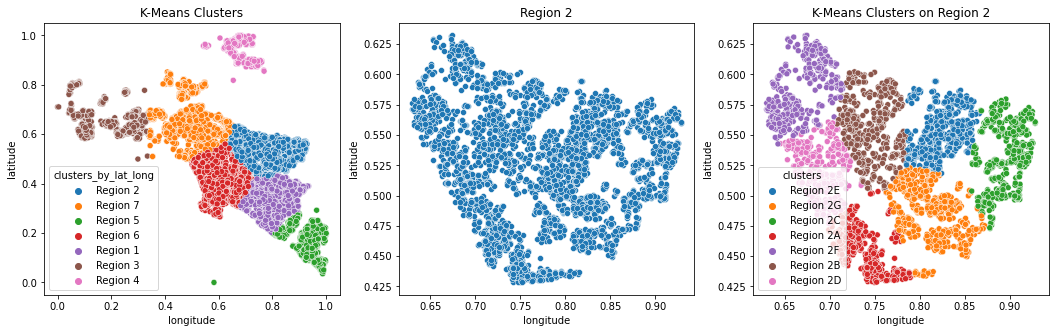

In [387]:
plt.figure(figsize=(18,5))
plt.subplot(131)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'clusters_by_lat_long', palette = ('tab10'))
plt.title('K-Means Clusters')

plt.subplot(132)
sns.scatterplot(data = Region_2, x = 'longitude', y = 'latitude')
plt.title('Region 2')

plt.subplot(133)
sns.scatterplot(data = Region_2, x = 'longitude', y = 'latitude', hue = 'clusters', palette = ('tab10'))
plt.title('K-Means Clusters on Region 2')

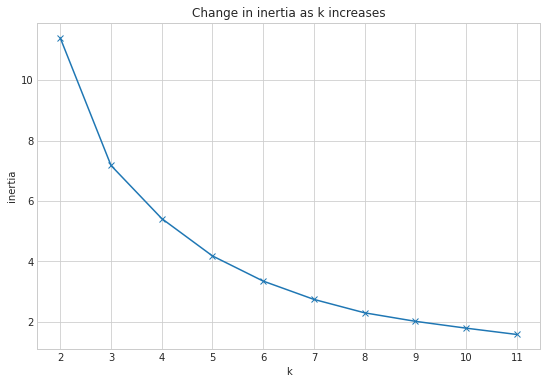

In [349]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [356]:
def map_clusters(df):
     # identified counties for fips codes 
    clusters = {0: 'Region 2A',
                 1: 'Region 2B',
                 2: 'Region 2C',
                 3: 'Region 2D',
                 4: 'Region 2E',
                 5: 'Region 2F',
                 6: 'Region 2G'}
     # map clusters 
    df.clusters= df.clusters.map(clusters)
    return df

In [358]:
map_clusters(Region_2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,...,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long,clusters_scaled,clusters
51081,1.000000,0.666667,0.775477,Los_Angeles,0.582710,0.819429,0.288785,37015,96464,1.000000,...,8650,0.033457,2017-09-11,Single Family Residential,0.000000,0.318182,1.000,NaN,1,Region 2E
14377,0.333333,0.333333,0.489152,Los_Angeles,0.518610,0.812801,0.835651,14542,96524,0.428571,...,4492,0.037286,2017-03-29,Single Family Residential,0.571429,0.319865,0.250,NaN,5,Region 2G
8180,0.000000,0.333333,0.159106,Los_Angeles,0.499864,0.899806,0.521492,20008,96506,0.438776,...,2904,0.001910,2017-02-24,Single Family Residential,0.561224,0.380471,0.125,NaN,0,Region 2C
9527,0.000000,0.333333,0.153846,Los_Angeles,0.562970,0.815496,0.670309,37015,96464,0.397959,...,6457,0.005400,2017-03-02,Single Family Residential,0.602041,0.530303,0.250,NaN,0,Region 2E
11958,0.333333,0.666667,0.314596,Los_Angeles,0.497940,0.802559,0.573144,118694,96488,0.469388,...,950,0.044555,2017-03-16,Single Family Residential,0.530612,0.053872,0.250,NaN,5,Region 2G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32993,0.666667,0.666667,0.556870,Los_Angeles,0.546752,0.730859,0.585064,14111,96517,0.408163,...,1475,-0.020068,2017-06-21,Single Family Residential,0.591837,0.062290,0.625,NaN,4,Region 2B
35969,0.333333,0.000000,0.401052,Los_Angeles,0.556810,0.914502,0.719704,30908,96469,0.469388,...,2245,0.001325,2017-06-30,Single Family Residential,0.530612,0.143098,0.625,NaN,5,Region 2C
14450,0.333333,0.666667,0.618343,Orange,0.431345,0.784063,0.920354,18874,96186,0.397959,...,1179,0.003293,2017-03-29,Single Family Residential,0.602041,0.052189,0.250,NaN,4,Region 2A
2462,0.666667,0.333333,0.462853,Los_Angeles,0.610576,0.695374,0.576937,30187,96265,0.346939,...,3259,0.001447,2017-01-18,Single Family Residential,0.653061,0.218855,0.000,NaN,5,Region 2F


In [362]:
Region_2.groupby('clusters').logerror.mean()

clusters
Region 2A    0.003877
Region 2B    0.006094
Region 2C    0.008434
Region 2D   -0.007870
Region 2E    0.004621
Region 2F   -0.002231
Region 2G    0.003313
Name: logerror, dtype: float64

### Region 2C

In [364]:
Region_2C = Region_2[Region_2.clusters == 'Region 2C']

In [390]:
Region_2C.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,age,taxvalue_per_sqft,month_of_sale,clusters_scaled
bathroomcnt,1.000000,0.567279,0.752595,0.064595,-0.248372,0.338430,0.267563,-0.133131,0.584609,0.403658,0.410394,0.016715,-0.584609,-0.016613,0.033586,0.413864
bedroomcnt,0.567279,1.000000,0.651933,0.066300,-0.129583,0.362156,0.184780,-0.102754,0.379947,0.274111,0.290268,-0.024454,-0.379947,-0.092656,0.091483,0.314255
calculatedfinishedsquarefeet,0.752595,0.651933,1.000000,0.154720,-0.189283,0.541418,0.356706,-0.230806,0.472169,0.497688,0.506720,0.039951,-0.472169,-0.065931,0.033954,0.518597
latitude,0.064595,0.066300,0.154720,1.000000,0.299795,0.232853,0.652974,-0.518037,-0.080275,0.036031,0.012712,0.117374,0.080275,-0.044506,0.059664,0.242169
longitude,-0.248372,-0.129583,-0.189283,0.299795,1.000000,-0.023728,-0.169702,-0.543639,-0.383715,-0.188225,-0.191822,0.041846,0.383715,-0.089410,-0.026808,-0.080962
lotsizesquarefeet,0.338430,0.362156,0.541418,0.232853,-0.023728,1.000000,0.340333,-0.355760,0.218626,0.244536,0.252269,0.140867,-0.218626,-0.055010,0.074574,0.431140
regionidcity,0.267563,0.184780,0.356706,0.652974,-0.169702,0.340333,1.000000,-0.440564,0.240280,0.247237,0.229197,0.060843,-0.240280,0.076572,0.053228,0.289596
regionidzip,-0.133131,-0.102754,-0.230806,-0.518037,-0.543639,-0.355760,-0.440564,1.000000,0.057353,-0.102501,-0.102278,-0.051111,-0.057353,0.003843,-0.014993,-0.283452
yearbuilt,0.584609,0.379947,0.472169,-0.080275,-0.383715,0.218626,0.240280,0.057353,1.000000,0.350967,0.358031,0.002329,-1.000000,0.093936,-0.040353,0.226174
taxvaluedollarcnt,0.403658,0.274111,0.497688,0.036031,-0.188225,0.244536,0.247237,-0.102501,0.350967,1.000000,0.980451,-0.033906,-0.350967,0.796208,-0.008855,0.218930


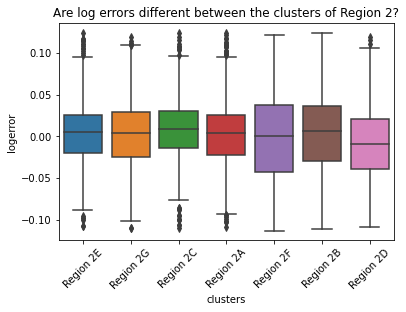

In [400]:
sns.boxplot(data=Region_2,x='clusters',y='logerror')
plt.title("Are log errors different between the clusters of Region 2?")
plt.xticks(rotation=45)
plt.show()

In [375]:
X_train = Region_2C.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                      'clusters_scaled', 'clusters_by_lat_long','clusters'])
y_train = Region_2C['logerror']

X_validate = Region_2C.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                            'clusters_scaled', 'clusters_by_lat_long', 'clusters'])
y_validate = Region_2C['logerror']

X_test = Region_2C.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet','regionidcity', 'regionidcity', 
                                      'regionidzip', 'yearbuilt', 'taxvaluedollarcnt',
                                     'taxamount', 'logerror', 'transactiondate', 
                                      'propertylandusedesc', 'taxvalue_per_sqft', 'month_of_sale', 
                                    'clusters_scaled', 'clusters_by_lat_long', 'clusters'])
y_test = Region_2C['logerror']

In [376]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [377]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [378]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [379]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [380]:
# create the model
lm3 = LinearRegression(normalize=True)

In [381]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [382]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [383]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [384]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [385]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [386]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.03985896336896752 
Validation/Out-of-Sample:  0.03985896336896752


### Test the model